# Exercise 6.10: Stochastic Wind Gridworld

Now we consider stochastic wind. With probability p = 1/3 the wind is wind_mean, as indicated in the world map for each column. And with probabilities 1/3 it is either wind_mean + 1 or wind_mean - 1.

The main significant difference in the implementation is in sarsa method with StochasticWindWorld class. Namely, when we compute the next state. Another difference is in generating episodes from the trained greedy policy.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
np.random.seed(42)

In [4]:
def create_world():
    w = np.zeros((7,10), dtype=int)

    # Add winds 
    w[:, 0:3] = 0
    w[:, 3:6] = 1
    w[:, 6:8] = 2
    w[:, 8]   = 1
    w[:, 9]   = 0 
    
    return w

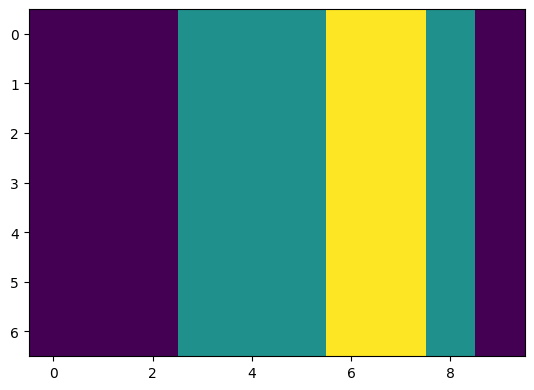

In [5]:
w = create_world()
plt.imshow(w)
plt.show()

In [29]:
class StochasticWindWorld:

    HUMAN = 10


    def __init__(self, world, Q_ave = 0, sigma = 1, include_no_move_action = False):
        
        self.world = world
        self.shape = world.shape
        self.H, self.L = self.shape[0], self.shape[1]

        self.start = (3,0)
        self.goal = (3,7)
        
        self.no_move = include_no_move_action
        self.nA = 8   # number of actions

        if self.no_move:
            self.nA += 1

        self.S_A_shape = self.shape + (self.nA,)

        self.action_to_dir = {0: (0,1),
                              1: (0,-1),
                              2: (1,0),
                              3: (-1,0),
                              4: (1,1),
                              5: (1,-1),
                              6: (-1,1),
                              7: (-1,-1),
                                }
        if self.no_move:
            self.action_to_dir[8] = (0,0)

        self.dir_to_action = {v:k for k,v in self.action_to_dir.items()}
        self.allowed_actions = {(x,y): self.get_allowed_actions((x,y)) for x in range(self.H) for y in range(self.L)} # allowed actions for a given state


        self.Q = self.Q_init(Q_ave, sigma)
        self.pi_greedy = np.argmax(self.Q, axis=-1)

        self.state = None # (x,y) - position on the grid

    
    def Q_init(self, Q_ave, sigma):

        Q = Q_ave + sigma*np.random.randn(*self.S_A_shape)
        
        # Set value of the Goal state to zero
        Q[self.goal] = 0

        # Maks disallowed actions at the borders of the world

        for x in range(self.shape[0]):
            for y in range(self.shape[1]):
                state = (x,y)
                allowed_actions = self.allowed_actions[state]

                for a in range(8):
                    if a not in allowed_actions:
                        Q[state + (a,)] = float('-inf')

        return Q
    

    def get_allowed_actions(self, state):

        x,y  = state
        H, L = self.shape

        allowed_actions = []

        for dx in range(-1,2):
            for dy in range(-1,2):
                x_next, y_next = x + dx, y + dy
                if (x_next, y_next) != (x,y) and 0 <= x_next < H and 0 <= y_next < L:
                    allowed_actions.append(self.dir_to_action[(dx,dy)])
        
        if self.no_move:
            allowed_actions.append(self.dir_to_action[(0,0)])
        
        return allowed_actions

    

    def eps_greedy(self, state, eps):

        p = np.random.rand()

        if p > eps:
            return self.pi_greedy[state]
        
        
        allowed_actions = self.allowed_actions[state]
        return np.random.choice(allowed_actions)
    
        
    def reset(self):
        self.state = self.start

    
    def sarsa(self, n_episodes, alpha, eps):


        curr_time_step = 0
        logs = [curr_time_step]  # current time at the end of each episode

        for i in tqdm(range(n_episodes)):

            self.reset()
            tot_reward = 0
            action = self.eps_greedy(self.state, eps)


            while self.state != self.goal:

                dx, dy = self.action_to_dir[action]
                tot_reward -= 1

                
                # Last term is the wind in negative x direction (upward). 
                # Include stochastic wind
                noise = np.random.randint(-1,2)
                
                x_next = self.state[0] + dx - self.world[self.state] + noise

                # Clip from both sides, since the wind can be in both directions.
                x_next = max(0, x_next)
                x_next = min(self.H-1, x_next)

                y_next = self.state[1] + dy
                
                next_state = (x_next, y_next)
                next_action = self.eps_greedy(next_state, eps)

              
                self.Q[self.state + (action,)] += alpha * (-1 + self.Q[next_state + (next_action,)] - self.Q[self.state + (action,)] )
                self.pi_greedy[self.state] = np.argmax(self.Q[self.state])

                self.state = next_state
                action = next_action

                curr_time_step += 1
                
            
            logs.append(curr_time_step)
        
        
        return logs 
    

    def generate_greedy_episode(self, render = True):

        self.reset()
        tot_reward = 0
        # action = self.pi_greedy[self.state]

        path = [self.state]

        while self.state != self.goal:

            # Get action
            action = self.pi_greedy[self.state]
            dx, dy = self.action_to_dir[action]

            # Get reward
            tot_reward -= 1

            # Next state
            x_next = self.state[0] + dx - self.world[self.state] + np.random.randint(-1,2)

            # Clip from both sides, since the wind can be in both directions.
            x_next = max(0, x_next)
            x_next = min(self.H-1, x_next)
              
            y_next = self.state[1] + dy
            
            self.state = (x_next, y_next)
            path.append(self.state)

        
        if render:
            
            print(f"Goal reached in {len(path)-1} steps.")

            world_map = self.world.copy()
            
            for state in path:
                world_map[state] = self.HUMAN

            plt.imshow(world_map)
            plt.show()


In [30]:
g = StochasticWindWorld(w)

In [31]:
logs = g.sarsa(n_episodes = 500, alpha = 0.5, eps = 0.1)

  0%|          | 0/500 [00:00<?, ?it/s]

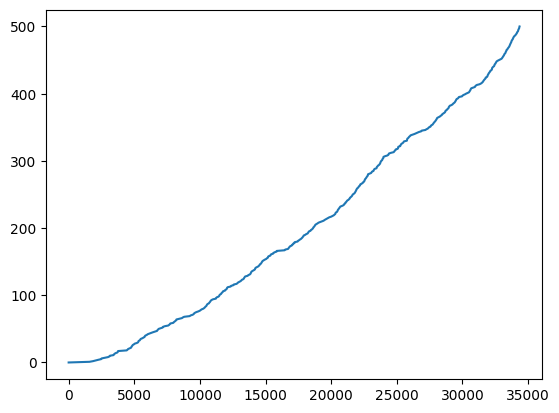

In [32]:
plt.plot(logs, range(len(logs)))
plt.show()

Now let's generate several episodes with stochastic wind, using the trained greedy policy.

Goal reached in 22 steps.


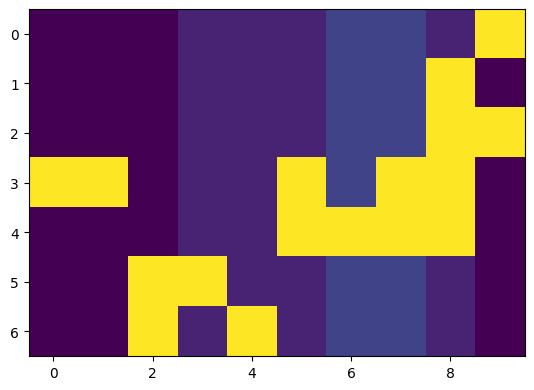

Goal reached in 37 steps.


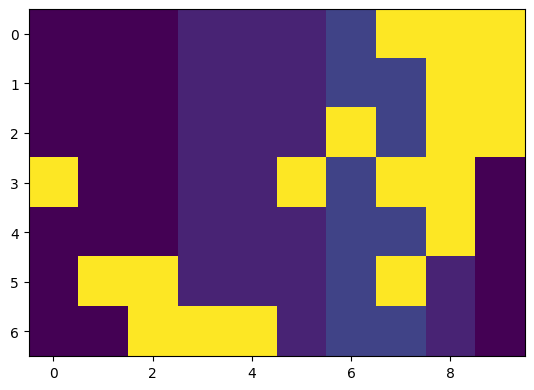

Goal reached in 18 steps.


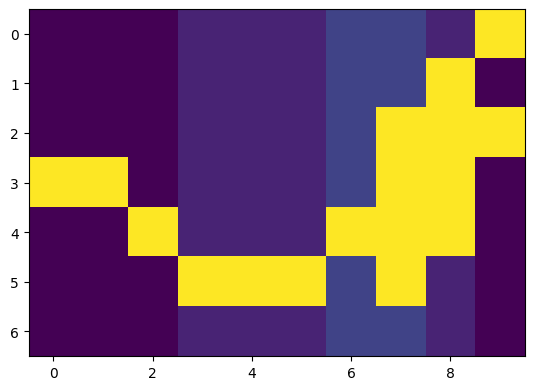

Goal reached in 7 steps.


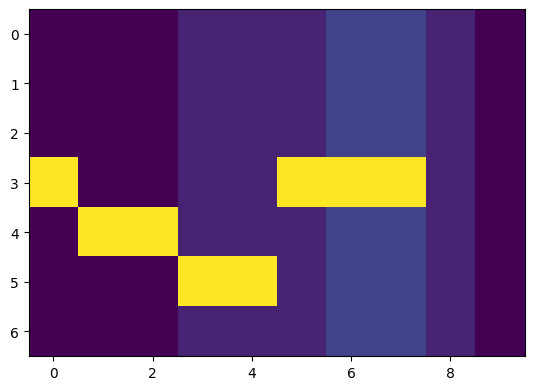

In [45]:
for i in range(4):
    g.generate_greedy_episode()

We get a wide range of paths, some are long some are short.